In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl

Etude : ergodicité et stationnarité

In [ ]:
#???

Définitions de fonctions

In [ ]:
def predicteurlineaire(signal, degre):
    n = signal.shape[0]
    signal_CR = (signal - np.mean(signal))/np.var(signal)
    signal_autocorr = np.correlate(signal_CR, signal_CR, "full")
    autocorr = signal_autocorr[n-1:]
    mat_toeplitz = scl.toeplitz(autocorr[0:degre])
    b = -autocorr[1:degre+1].reshape(degre,1)
    return scl.solve(mat_toeplitz,b)

xcorr = lambda X,Y:np.correlate(X,Y,mode='full')
def predicteurlineaire_step(x,step,p):
    n = x.shape[0]
    RXX = xcorr(x,x)[n-1:]
    #Ryy*h=ry[step:step+degre]
    return scl.solve_toeplitz(RXX[:p], RXX[step:step+p]) #on prend jusque p car on est en python, en théorie on prend jusqu'à p-1

def degre_max(taille_echantillon, step_max):
    return taille_echantillon - step_max

Prédiction d'un intervalle 

Changements de temporalité : quotidien, hebdomadaire, mensuel

QUOTIDIEN

In [ ]:
nRowsRead1 = 259
CAC_quotidien = pd.read_csv('CAC_quotidien.csv', delimiter=',', nrows = nRowsRead1)
CAC_hebdo = pd.read_csv('CAC_hebdo.csv', delimiter=',', nrows = nRowsRead1)
CAC_mensuel = pd.read_csv('CAC_mensuel.csv', delimiter=',', nrows = nRowsRead1)

Evaluation du degre du filtre : hyper-paramètre

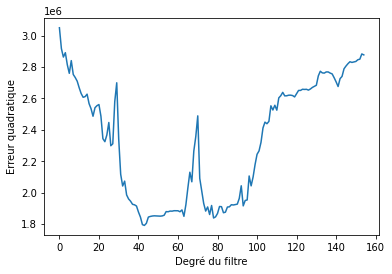

Le degré optimale du filre est : 43


In [ ]:
taille_totale = 259
taille_echantillon = int(np.round(taille_totale*0.8))
size = int(np.round(taille_totale*0.2))
signal = CAC_quotidien["Close"]
X = signal[:taille_echantillon]
X_theorique = signal[:taille_totale]

estimation = np.zeros(size)
mean = np.mean(X)
var = np.var(X)
X_CR = (X - mean)/var

p_max = degre_max(taille_echantillon,size)
erreur_quad = np.zeros(p_max)

for p in range(1,p_max+1):
    for i in range(1, size+1):
        coeff = predicteurlineaire_step(X_CR, i, p)
        estimation[i-1] = np.inner(np.flip(X_CR[-p:]),coeff.reshape(p))
        estimation[i-1] = estimation[i-1]*var + mean

    erreur_quad[p-1] = pd.Series.sum((estimation-X_theorique[taille_echantillon:size+taille_echantillon])**2)

plt.figure()
plt.xlabel("Degré du filtre")
plt.ylabel("Erreur quadratique")
plt.plot(erreur_quad)
plt.show()

print("Le degré optimale du filre est :",np.argmin(erreur_quad))

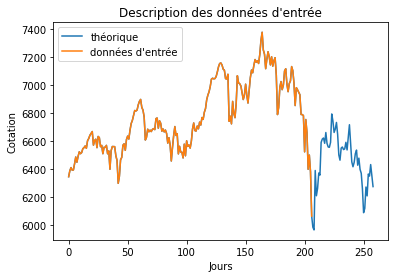

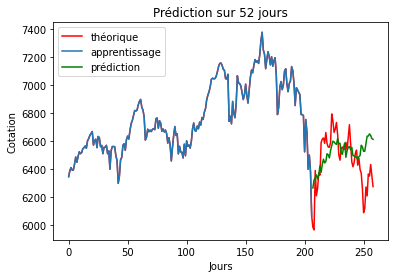

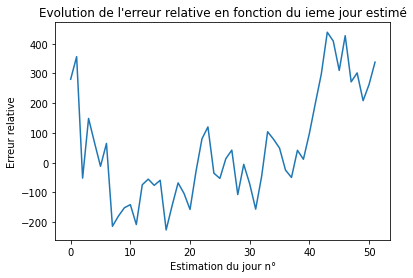

In [ ]:
p = 43 ##estimé par le code sur l'optimisation de l'hyper-paramètre

taille_totale = 259
taille_echantillon = int(np.round(taille_totale*0.8))
size = int(np.round(taille_totale*0.2))
signal = CAC_quotidien["Close"]
X = signal[:taille_echantillon]
X_theorique = signal[:taille_totale]

plt.figure()
plt.title("Description des données d'entrée")
plt.xlabel("Jours")
plt.ylabel("Cotation")
plt.plot(X_theorique, label="théorique")
plt.plot(X, label="données d'entrée")
plt.legend()
plt.show()

mean = np.mean(X)
var = np.var(X)
X_CR = (X - mean)/var

estimation = np.zeros(size)
for i in range(1, size+1):
    coeff = predicteurlineaire_step(X_CR, i, p)
    estimation[i-1] = np.inner(np.flip(X_CR[-p:]),coeff.reshape(p))
    estimation[i-1] = estimation[i-1]*var + mean

plt.figure()
plt.title("Prédiction sur 52 jours")
plt.xlabel("Jours")
plt.ylabel("Cotation")
plt.plot(X_theorique, 'r', label="théorique")
plt.plot(X, label="apprentissage")
plt.plot(np.arange(taille_echantillon,taille_echantillon+size),estimation,'g', label="prédiction")
plt.legend()
plt.show()

plt.figure()
plt.title("Evolution de l'erreur relative en fonction du ieme jour estimé")
plt.xlabel("Estimation du jour n°")
plt.ylabel("Erreur relative")
plt.plot(np.arange(size),(estimation-X_theorique[taille_echantillon:size+taille_echantillon]))
plt.show()

Essai de prédiction quotidienne en retirant la tendance haussière : 

[2.75115575e+00 6.48997879e+03]


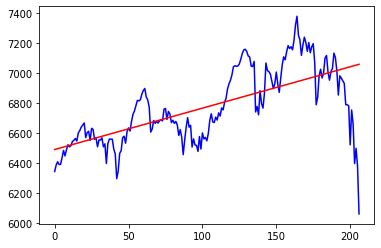

In [ ]:
n = X.shape[0]
t=np.arange(0,n)
poly=np.polyfit(t,X,1)
print(poly)
linear_trend = np.polyval(poly,t)

plt.figure()
plt.plot(X,'b-')
plt.plot(linear_trend,'r-')
plt.show()

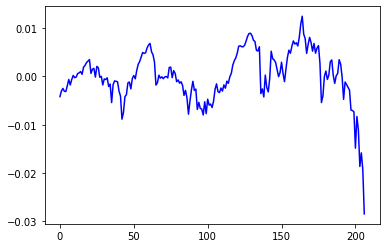

In [ ]:
sig_s = X - linear_trend
sig_sMean = sig_s.mean()
sig_sVar = sig_s.var()
sig_s_CR = (sig_s - sig_sMean) / sig_sVar
plt.plot(sig_s_CR,'b-')

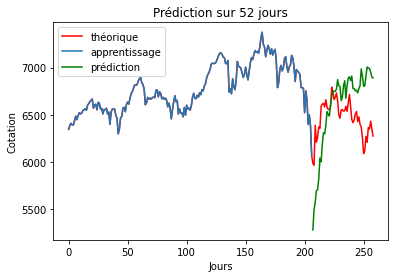

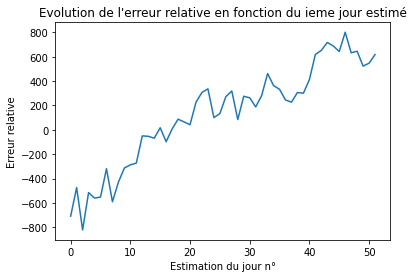

In [ ]:
estimation = np.zeros(size)
for i in range(1, size+1):
    coeff = predicteurlineaire_step(sig_s_CR, i, p)
    estimation[i-1] = np.inner(np.flip(sig_s_CR[-p:]),coeff.reshape(p))
    estimation[i-1] = estimation[i-1]*X_theorique.var() + X_theorique.mean()

plt.figure()
plt.title("Prédiction sur 52 jours")
plt.xlabel("Jours")
plt.ylabel("Cotation")
plt.plot(X_theorique, 'r', label="théorique")
plt.plot(X, label="apprentissage")
plt.plot(np.arange(taille_echantillon,taille_echantillon+size),estimation,'g', label="prédiction")
plt.legend()
plt.show()

plt.figure()
plt.title("Evolution de l'erreur relative en fonction du ieme jour estimé")
plt.xlabel("Estimation du jour n°")
plt.ylabel("Erreur relative")
plt.plot(np.arange(size),(estimation-X_theorique[taille_echantillon:size+taille_echantillon]))
plt.show()

HEBDOMADAIRE

Evaluation du degre du filtre : hyper-paramètre

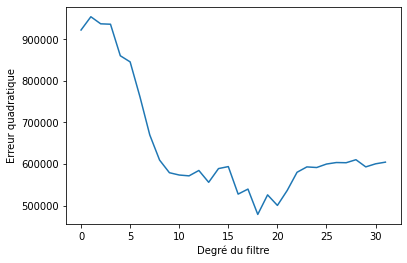

Le degré optimale du filre est : 18


In [ ]:
taille_totale = 54
taille_echantillon = int(np.round(taille_totale*0.8))
size = int(np.round(taille_totale*0.2))
signal = CAC_hebdo["Close"]
X = signal[:taille_echantillon]
X_theorique = signal[:taille_totale]

estimation = np.zeros(size)
mean = np.mean(X)
var = np.var(X)
X_CR = (X - mean)/var

p_max = degre_max(taille_echantillon,size)
erreur_quad = np.zeros(p_max)

for p in range(1,p_max+1):
    for i in range(1, size+1):
        coeff = predicteurlineaire_step(X_CR, i, p)
        estimation[i-1] = np.inner(np.flip(X_CR[-p:]),coeff.reshape(p))
        estimation[i-1] = estimation[i-1]*var + mean

    erreur_quad[p-1] = pd.Series.sum((estimation-X_theorique[taille_echantillon:size+taille_echantillon])**2)

plt.figure()
plt.xlabel("Degré du filtre")
plt.ylabel("Erreur quadratique")
plt.plot(erreur_quad)
plt.show()

print("Le degré optimale du filre est :",np.argmin(erreur_quad))

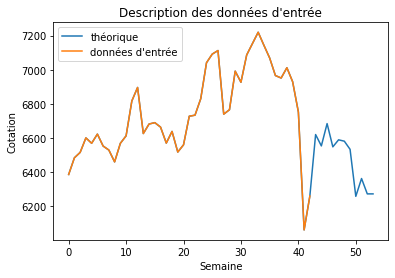

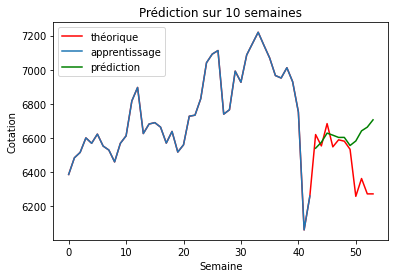

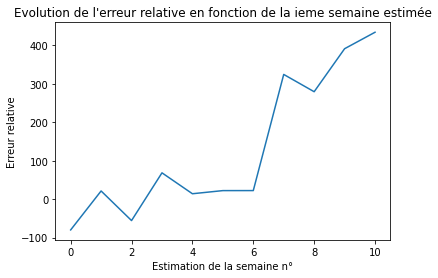

In [ ]:
p = 18  ##estimé par le code sur l'optimisation de l'hyper-paramètre

taille_totale = 54
taille_echantillon = int(np.round(taille_totale*0.8))
size = int(np.round(taille_totale*0.2))
signal = CAC_hebdo["Close"]
X = signal[:taille_echantillon]
X_theorique = signal[:taille_totale]

plt.figure()
plt.title("Description des données d'entrée")
plt.xlabel("Semaine")
plt.ylabel("Cotation")
plt.plot(X_theorique, label="théorique")
plt.plot(X, label="données d'entrée")
plt.legend()
plt.show()

mean = np.mean(X)
var = np.var(X)
X_CR = (X - mean)/var

estimation = np.zeros(size)
for i in range(1, size+1):
    coeff = predicteurlineaire_step(X_CR, i, p)
    estimation[i-1] = np.inner(np.flip(X_CR[-p:]),coeff.reshape(p))
    estimation[i-1] = estimation[i-1]*var + mean

plt.figure()
plt.title("Prédiction sur 10 semaines")
plt.xlabel("Semaine")
plt.ylabel("Cotation")
plt.plot(X_theorique, 'r', label="théorique")
plt.plot(X, label="apprentissage")
plt.plot(np.arange(taille_echantillon,taille_echantillon+size),estimation,'g', label="prédiction")
plt.legend()
plt.show()

plt.figure()
plt.title("Evolution de l'erreur relative en fonction de la ieme semaine estimée")
plt.xlabel("Estimation de la semaine n°")
plt.ylabel("Erreur relative")
plt.plot(np.arange(size),(estimation-X_theorique[taille_echantillon:size+taille_echantillon]))
plt.show()

MENSUEL

Evaluation du degre du filtre : hyper-paramètre

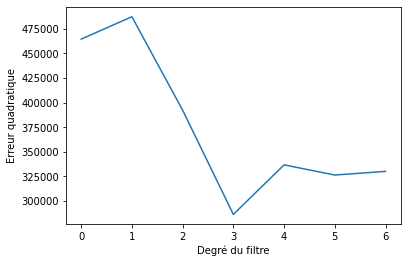

Le degré optimale du filre est : 3


In [ ]:
taille_totale = 13
taille_echantillon = int(np.round(taille_totale*0.8))
size = int(np.round(taille_totale*0.2))
signal = CAC_mensuel["Close"]
X = signal[:taille_echantillon]
X_theorique = signal[:taille_totale]


estimation = np.zeros(size)
mean = np.mean(X)
var = np.var(X)
X_CR = (X - mean)/var

p_max = degre_max(taille_echantillon,size)
erreur_quad = np.zeros(p_max)

for p in range(1,p_max+1):
    for i in range(1, size+1):
        coeff = predicteurlineaire_step(X_CR, i, p)
        estimation[i-1] = np.inner(np.flip(X_CR[-p:]),coeff.reshape(p))
        estimation[i-1] = estimation[i-1]*var + mean

    erreur_quad[p-1] = pd.Series.sum((estimation-X_theorique[taille_echantillon:size+taille_echantillon])**2)

plt.figure()
plt.xlabel("Degré du filtre")
plt.ylabel("Erreur quadratique")
plt.plot(erreur_quad)
plt.show()

print("Le degré optimale du filre est :",np.argmin(erreur_quad))

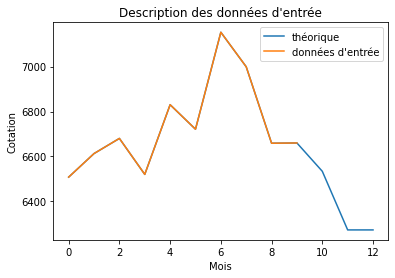

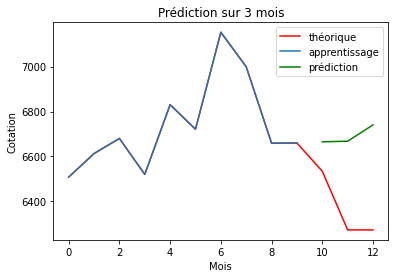

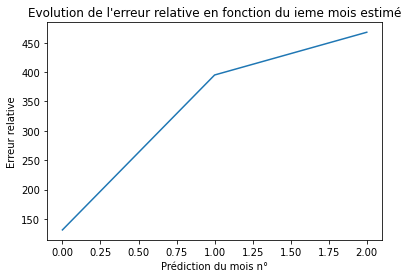

In [ ]:
p = 3  ##estimé par le code sur l'optimisation de l'hyper-paramètre

taille_totale = 13
taille_echantillon = int(np.round(taille_totale*0.8))
size = int(np.round(taille_totale*0.2))
signal = CAC_mensuel["Close"]
X = signal[:taille_echantillon]
X_theorique = signal[:taille_totale]

plt.figure()
plt.title("Description des données d'entrée")
plt.xlabel("Mois")
plt.ylabel("Cotation")
plt.plot(X_theorique, label="théorique")
plt.plot(X, label="données d'entrée")
plt.legend()
plt.show()

mean = np.mean(X)
var = np.var(X)
X_CR = (X - mean)/var
estimation = np.zeros(size)

for i in range(1, size+1):
    coeff = predicteurlineaire_step(X_CR, i, p)
    estimation[i-1] = np.inner(np.flip(X_CR[-p:]),coeff.reshape(p))
    estimation[i-1] = estimation[i-1]*var + mean

plt.figure()
plt.title("Prédiction sur 3 mois")
plt.xlabel("Mois")
plt.ylabel("Cotation")
plt.plot(X_theorique, 'r', label="théorique")
plt.plot(X, label="apprentissage")
plt.plot(np.arange(taille_echantillon,taille_echantillon+size),estimation,'g', label="prédiction")
plt.legend()
plt.show()

plt.figure()
plt.title("Evolution de l'erreur relative en fonction du ieme mois estimé")
plt.xlabel("Prédiction du mois n°")
plt.ylabel("Erreur relative")
plt.plot(np.arange(size),(estimation-X_theorique[taille_echantillon:size+taille_echantillon]))
plt.show()